In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import glob
import re
import seaborn as sns
import tensorflow as tf
import transformers
from transformers import TFBertForTokenClassification
from tqdm.notebook import tqdm
from scipy.stats import pearsonr

import sys
sys.path.append("..")
from data_preparation.data_preparation_pos import ABSATokenizer, convert_examples_to_tf_dataset, read_conll
import utils.utils as utils
import utils.pos_utils as pos_utils
import utils.postprocessing_utils as post_utils

#<img src="attachment:image.png" width="300" height="300" align="left">
"""
<hr>
<a id=""></a>

[Back to contents](#index)
""";

<a id="index"></a>

[A.1. Dev-Test Performance Loss](#A1)
<div style="max-width: 40%;max-height: 30%;display: inline-block;">
    <img src="../results/plots/pos_accuracy_drop_devtest.png">
</div>

[A.2. Below baseline?](#A2)

[A.3. Training Data Size vs Within-Language Performance](#A3)

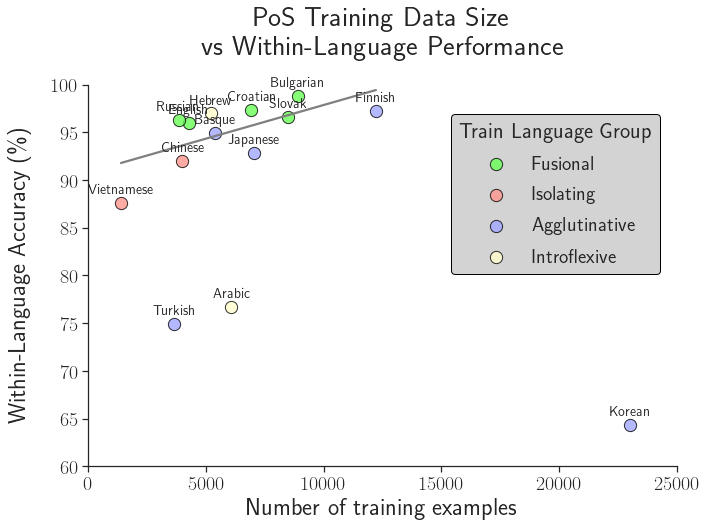

[A.4. The Effect of Word Splits and Average Length](#A4)

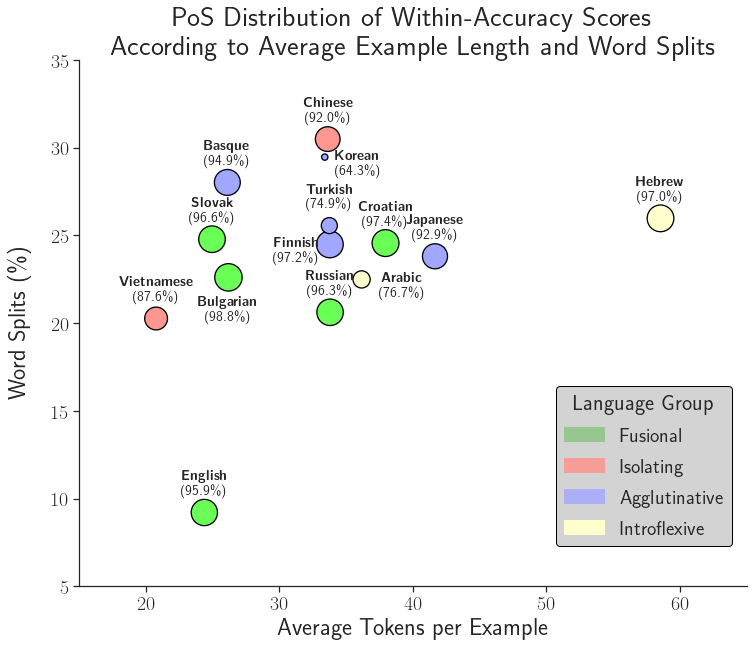

[A.5. PUD vs Other Test](#A5)

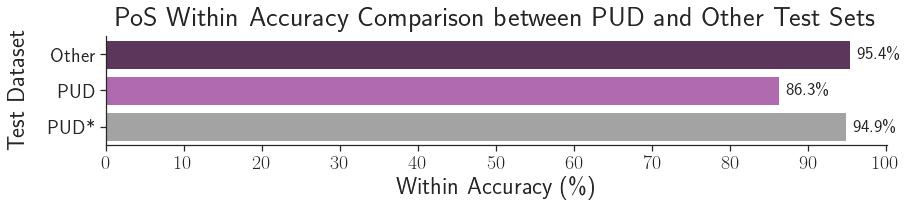

<hr>
<a id="A1"></a>

[Back to contents](#index)

### A.1. Dev-Test Performance Loss

In [11]:
code_dicts = utils.make_lang_code_dicts()
code_to_name = code_dicts["code_to_name"]
name_to_code = code_dicts["name_to_code"]

In [12]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [13]:
# Model parameters
max_length = 256
batch_size = 256
model_name = "bert-base-multilingual-cased"
tagset = ["O", "_", "ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", 
          "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]
num_labels = len(tagset)
label_map = {label: i for i, label in enumerate(tagset)}

# Model creation and loading weights
tokenizer = ABSATokenizer.from_pretrained(model_name)
config = transformers.BertConfig.from_pretrained(model_name, num_labels=num_labels)
model = TFBertForTokenClassification.from_pretrained(model_name,
                                                     config=config)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertForTokenClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
pos_eval = []
data_dir = "../data/ud/"
weights_filename = model_name + "_pos.hdf5"

for directory in tqdm(["ko", "tr", "ar"]):
    row_eval = {"Language": code_to_name[directory]}
    weights_path = "E:/TFM_CCIL/checkpoints/" + directory + "/"
    model.load_weights(weights_path + weights_filename)
    
    for dataset_name in ["dev", "test"]:
    # Load and preprocess
        path = os.path.join(data_dir, directory)
        test_examples, test_dataset = pos_utils.load_data(path, batch_size, tokenizer, tagset, max_length, dataset_name)

        # Predict
        preds = model.predict(test_dataset, steps=np.ceil(len(test_examples) / batch_size), verbose=1)

        # Postprocessing
        tokens, labels, filtered_preds, logits = pos_utils.filter_padding_tokens(test_examples, preds, label_map, tokenizer)
        subword_locations = pos_utils.find_subword_locations(tokens)
        new_tokens, new_labels, new_preds = pos_utils.reconstruct_subwords(subword_locations, tokens, labels, 
                                                                           filtered_preds, logits)

        # Metrics
        accuracy = (np.array(new_labels) == np.array(new_preds)).mean()
        row_eval[dataset_name] = accuracy
    pos_eval.append(row_eval)

4/4 [==============================] - 12s 3s/step



In [15]:
df = pd.DataFrame(pos_eval)
df = pd.melt(df, id_vars=df.columns[0], value_vars=df.columns[1:]).rename(columns={"index": "Language",
                                                                                   "variable": "Dataset",
                                                                                   "value": "Accuracy"})
df["Accuracy"] = df["Accuracy"] * 100

In [16]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

In [17]:
df

,Language,Dataset,Accuracy
0,Korean,dev,96.277395
1,Turkish,dev,94.102813
2,Arabic,dev,97.193825
3,Korean,test,64.315002
4,Turkish,test,74.879619
5,Arabic,test,76.704737


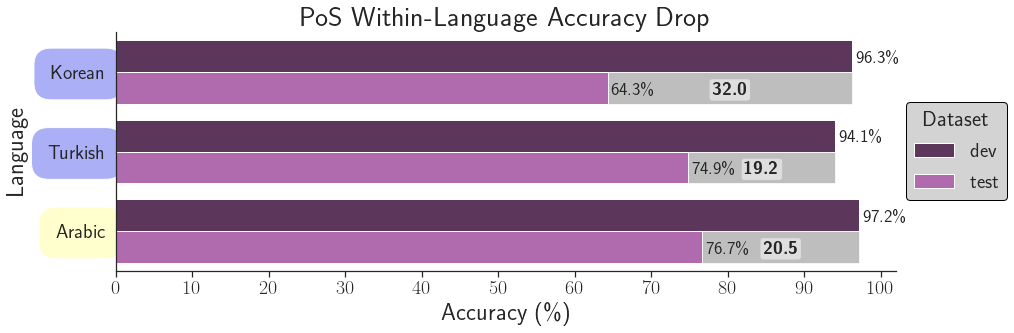

In [19]:
colors = {"dev": "#870c85", "test": "#ff1cfb"}
label_colors = ["#abaff5"] * 2 + ["#fffecc"]
extra_fontsize = 0

g = sns.catplot(
    data=df, kind="bar", x="Accuracy", y="Language", hue="Dataset",
    height=4, aspect=3, palette=colors, saturation=0.3, legend=False
)

langs = df["Language"].unique().tolist()

for lang in langs:
    values = df.loc[(df["Language"] == lang), "Accuracy"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(df.index[df["Language"] == lang]):
        p = "{:.1f}\%".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.5, langs.index(lang) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], langs.index(lang) + dy[i] + 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    g.ax.text(values.mean(), langs.index(lang) + dy[i] + extra_dy, r"\textbf{{{:.1f}}}".format(values[0] - values[1]), 
              verticalalignment="center", horizontalalignment="center", 
              fontsize=18 + extra_fontsize,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))

plt.legend(title="Dataset", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(1, 0.75), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.xticks(range(0, 101, 10))
plt.ylabel("Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Accuracy (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Within-Language Accuracy Drop", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_accuracy_drop_devtest.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

<hr>
<a id="A2"></a>

[Back to contents](#index)

### A.2. Below baseline?

In [13]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)
df = results["Accuracy"]["langvlang"]

In [14]:
basedif = df.drop("Thai", axis=1).iloc[:15, 2:-1].apply(lambda x: x - df.loc[:14, "Baseline"]) * 100
basedif.insert(0, "Test\Train", df["Test\Train"])

In [15]:
cond = basedif.iloc[:,1:] <= 5
basedif.loc[cond.any(axis=1)]

,Test\Train,Bulgarian,English,Russian,Slovak,Croatian,Chinese,Vietnamese,Finnish,Basque,Japanese,Korean,Turkish,Arabic,Hebrew
11,Korean,9.4549,10.6368,10.9865,3.73251,14.4175,4.93247,4.26918,16.8657,15.9491,5.6862,15.5813,16.3833,1.8753,13.2477


<hr>
<a id="A3"></a>

[Back to contents](#index)

### A.3. Training Data Size vs Within-Language Performance

In [57]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)
df = results["Accuracy"]["langvlang"].iloc[:15]

In [58]:
basic_stats = pd.read_excel("../data_exploration/pos_basic_stats.xlsx")

In [59]:
df = pd.DataFrame({"Train-Group": df["Group"], "Train-Language": df["Test\Train"], 
                   "Within-Accuracy": np.diagonal(df.iloc[:, 2:-1].values)})
df = pd.merge(df, basic_stats[["language", "train_examples"]], how="left", left_on="Train-Language", right_on="language")
df = df.drop(df.index[df["Train-Language"] == "Thai"], axis=0)
df["Within-Accuracy"] = df["Within-Accuracy"].astype(float) * 100

In [110]:
pearsonr(x=df["train_examples"][~df["Train-Language"].isin(["Korean", "Turkish", "Arabic"])], 
         y=df["Within-Accuracy"][~df["Train-Language"].isin(["Korean", "Turkish", "Arabic"])])

(0.6586419118373943, 0.0275401784915581)

In [111]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

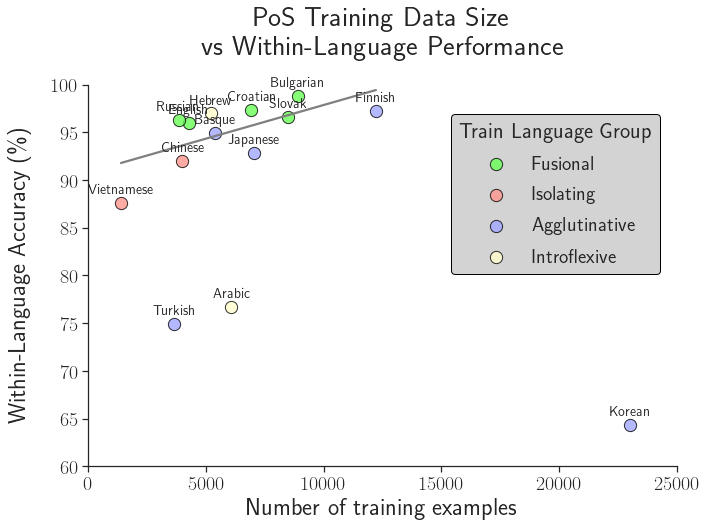

In [113]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="train_examples", y="Within-Accuracy", data=df, hue="Train-Group", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="train_examples", y="Within-Accuracy", data=df[~df["Train-Language"].isin(["Korean", "Turkish", "Arabic"])], 
            scatter=False, color="grey", ci=None)

for i, row in df.iterrows():
    plt.text(row["train_examples"], row["Within-Accuracy"] + 1, row["Train-Language"], fontsize=14, 
             horizontalalignment="center")

plt.legend(title="Train Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.6, 0.95), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.ylim((60,100))
plt.xlim((0,25000))
plt.ylabel("Within-Language Accuracy (\%)", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Number of training examples", fontsize=24 +  extra_fontsize)
plt.title("PoS Training Data Size \n vs Within-Language Performance", fontsize=28 +  extra_fontsize, pad=30)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_size_vs_within_accuracy.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

<hr>
<a id="A4"></a>

[Back to contents](#index)

### A.4. The Effect of Word Splits and Average Length

In [2]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)
df = results["Accuracy"]["langvlang"].iloc[:15]
df = df.rename(columns={"Test\Train": "Test Language"}).drop("Thai", axis=1)

In [3]:
new_df = df.iloc[:,:-1].copy()

In [4]:
within_scores = np.diagonal(df.drop(df.index[df["Test Language"] == "Thai"]).iloc[:,2:-1]).tolist()
within_scores.insert(new_df.index[new_df["Test Language"] == "Thai"][0], np.nan)

In [5]:
new_df["Within-Accuracy"] = within_scores

In [8]:
word_splits = pd.read_excel("../data_exploration/pos_split_word_stats.xlsx")

In [9]:
new_df = pd.concat([new_df, word_splits.iloc[:,1:]], axis=1)

In [15]:
new_df["test_avg_tokens"] = basic_stats["test_avg_tokens"]
new_df["train_examples"] = basic_stats["train_examples"]

In [63]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

In [17]:
new_df = new_df.rename(columns={"test_avg_tokens": "test-avg-tokens", "split_word_%": "split-word-percent"})

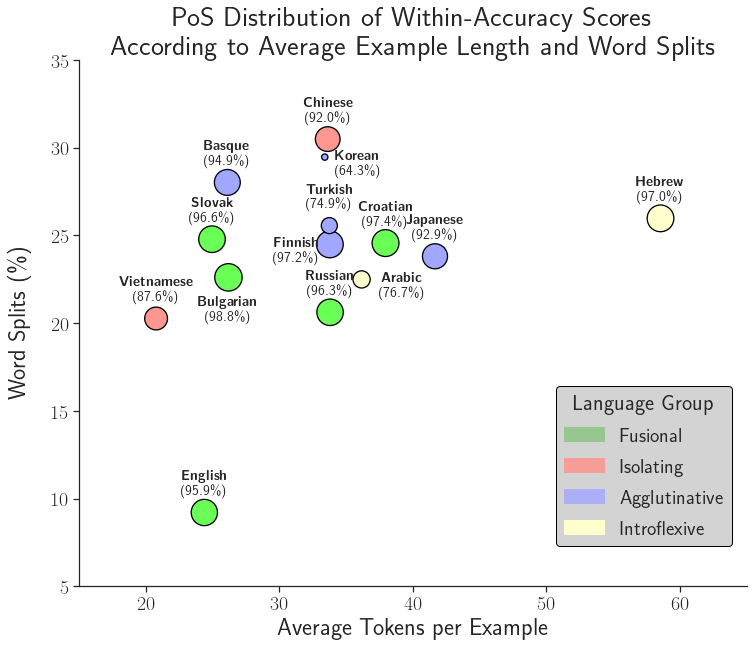

In [117]:
from matplotlib.patches import Patch

colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

data = new_df[new_df["Test Language"] != "Thai"]
x = "test-avg-tokens"
y = "split-word-percent"
hue = "Group"
size = "Within-Accuracy"
langs = "Test Language"

offsets = dict.fromkeys(data[langs].values, (0,1))
offsets["Korean"] = (2.5, -1)
offsets["Bulgarian"] = (0, -2.5)
offsets["Arabic"] = (3, -1)
offsets["Finnish"] = (-2.5, -1)

g = sns.relplot(x=x, y=y, data=data, hue=hue, palette=colors, legend=False, edgecolor="black",
            size=size, sizes=(40,750), height=8, aspect=1.25)

for i, row in data.iterrows():
    plt.text(row[x] + offsets[row[langs]][0], row[y] + offsets[row[langs]][1], 
             r"\textbf{{{}}}".format(row[langs]) + "\n({:.1f}\%)".format(row[size]*100), fontsize=14, 
             horizontalalignment="center")
    
h, l = g.ax.get_legend_handles_labels()
legend_patches = [Patch(color=color, label=label) for color, label in zip(["#95c78f", "#f79d97", "#abaff5", "#fffecc"],
                                                                          ["Fusional", "Isolating", "Agglutinative", 
                                                                           "Introflexive"])]
plt.legend(handles=legend_patches, title="Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.7, 0.4), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.ylim((5,35))
plt.xlim((15,65))
plt.ylabel("Word Splits (\%)", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Average Tokens per Example", fontsize=24 +  extra_fontsize)
plt.title("PoS Distribution of Within-Accuracy Scores \n According to Average Example Length and Word Splits", 
          fontsize=28 +  extra_fontsize, pad=0)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_length_word_splits_within_accuracy.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

<hr>
<a id="A5"></a>

[Back to contents](#index)

### A.5. PUD vs Other Test

In [111]:
df = pd.read_excel("../results/pos_within_cross_accuracy.xlsx")

In [112]:
df["Within-Accuracy"] = df["Within-Accuracy"] * 100

In [113]:
df_by_pud = df[["PUD", "Within-Accuracy"]].groupby("PUD", as_index=False).mean()
df_by_pud_without = df[~df["Test Language"].isin(["Korean", "Arabic", "Turkish", "Thai"])][["PUD", "Within-Accuracy"]].groupby(
    "PUD", as_index=False
).mean()
df_by_pud_without.loc[df_by_pud_without["PUD"] == "PUD", "PUD"] = "PUD*"

In [114]:
df_by_pud = pd.concat([df_by_pud, df_by_pud_without.loc[df_by_pud_without["PUD"] == "PUD*"]], ignore_index=True)

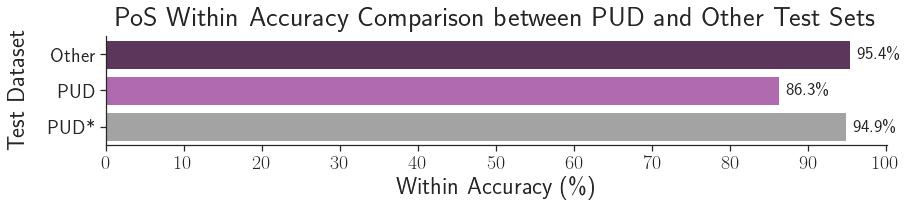

In [148]:
plt.figure(figsize=(14,2))
colors = ["#870c85", "#ff1cfb", "#a3a3a3"]
extra_fontsize = 0

ax = sns.barplot(data=df_by_pud, x="Within-Accuracy", y="PUD", palette=colors, saturation=0.3)

datasets = df_by_pud["PUD"].unique().tolist()

for dataset in datasets:
    value = df_by_pud.loc[(df_by_pud["PUD"] == dataset), "Within-Accuracy"].values[0]
    p = "{:.1f}\%".format(value)
    ax.text(value + 1, datasets.index(dataset), p, 
              verticalalignment="center", horizontalalignment="left", 
              fontsize=18 + extra_fontsize)
    
plt.xticks(range(0, 101, 10))
plt.ylabel("Test Dataset", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Within Accuracy (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Within Accuracy Comparison between PUD and Other Test Sets", 
          fontsize=28 +  extra_fontsize, pad=10)
plt.tick_params(labelsize=20)
    
sns.despine()

#plt.savefig("../results/plots/pos_pud_vs_other_within_accuracy.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [166]:
df = pd.read_excel("../results/pos_within_cross_accuracy.xlsx")

In [167]:
df = pd.concat([df, pd.read_excel("../data_exploration/pos_type_to_token.xlsx")[["test_ttr", "test_twr", 
                                                                                 "grez_ttr", "dif_grez_ttr_%"]]], 
               axis=1)

In [173]:
df["Within-Accuracy"] = df["Within-Accuracy"] * 100

In [191]:
df["train_examples"] = pd.read_excel("../data_exploration/pos_basic_stats.xlsx")["train_examples"]
df["test_examples"] = pd.read_excel("../data_exploration/pos_basic_stats.xlsx")["test_examples"]
df["test_avg_tokens"] = pd.read_excel("../data_exploration/pos_basic_stats.xlsx")["test_avg_tokens"]

In [221]:
df["test_twr_norm"] = df["test_twr"] / (df["test_examples"] * df["test_avg_tokens"])
df["Within-Accuracy-norm"] = df["Within-Accuracy"] / df["train_examples"]

In [264]:
df["reg"] = df["test_twr"] / df["test_avg_tokens"]
df["y"] = df["Within-Accuracy-norm"] * df["test_avg_tokens"]

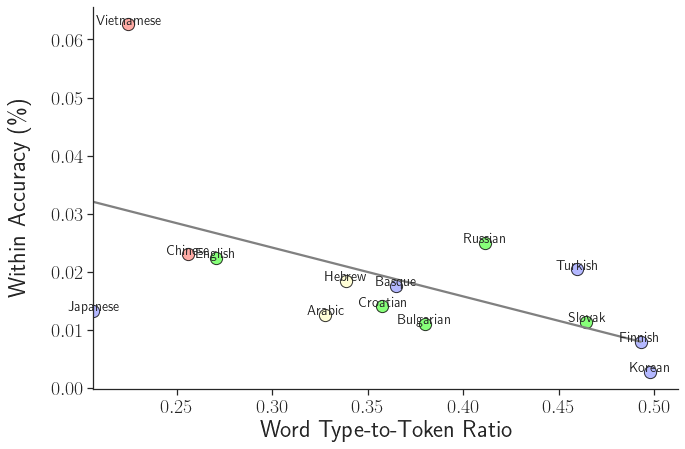

In [277]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

x = "test_twr"
y = "Within-Accuracy-norm"
hue = "Group"
langs = "Test Language"
data = df[df["Test Language"] != "Thai"]

g = sns.lmplot(x=x, y=y, data=data, hue=hue, palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x=x, y=y, data=data[~data[langs].isin(["Korean", "Turkish", "Arabic"])], 
            scatter=False, color="grey", ci=None)

for i, row in data.iterrows():
    plt.text(row[x], row[y], row[langs], fontsize=14, 
             horizontalalignment="center")

# plt.legend(title="Train Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
#            bbox_to_anchor=(0.6, 0.95), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
#            framealpha=1, edgecolor="black", labelspacing=0.6)

# plt.ylim((60,100))
# plt.xlim((0.15, 0.55))
plt.ylabel("Within Accuracy (%)".replace("_", " ").replace("%", "\%"), fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Word Type-to-Token Ratio".replace("_", " ").replace("%", "\%"), fontsize=24 +  extra_fontsize)
plt.title("", fontsize=28 +  extra_fontsize, pad=30)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_size_vs_within_accuracy.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [276]:
pearsonr(x=data[x],
         y=data[y])

(-0.5679758807362942, 0.03410141949736566)